## From paper: **Identification and Control of Dynamical Systems Using Neural Networks 1990**

### Example 1

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# plant dynamics or the funton we dont know  "black box" the one we are trying to learn
def plant_function(u):
    return 0.6 * np.sin(np.pi * u) + 0.3 * np.sin(3 * np.pi * u) + 0.1 * np.sin(5 * np.pi * u)

class SeriesParallelModel:
    def __init__(self, layers, step_size):
        self.layers = layers
        self.step_size = step_size
        self.weights = self.initialize_weights()

    def initialize_weights(self):
        weights = []
        for i in range(len(self.layers) - 1):
            weight = np.random.randn(self.layers[i], self.layers[i+1])
            weights.append(weight)
        return weights

    def forward(self, x):
        # x should be a single input value
        activation = np.array([x])
        for weight in self.weights:
            activation = np.tanh(np.dot(activation, weight))
        return activation[0]

    def train(self, x, target):
        # forawd pass agian to collect all the activation to do back prop on
        activations = [np.array([x])]
        for weight in self.weights:
            activation = np.tanh(np.dot(activations[-1], weight))
            activations.append(activation)
        
        #calc error and do the prop
        error = target - activations[-1]
        delta = error * (1 - activations[-1]**2)
        
        for i in range(len(self.weights)-1, -1, -1):
            gradient = np.outer(activations[i], delta) * self.step_size
            self.weights[i] += gradient
            if i > 0: #input layer doesnt need to be calc 
                delta = np.dot(delta, self.weights[i].T) * (1 - activations[i]**2)

        return error




In [102]:
def plotter(u, t, plant_output, model_output, title):   
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16)
    plt.subplot(2, 1, 1)
    plt.plot(t, plant_output, 'b-', label='Plant Output')
    plt.plot(t, model_output, 'r--', label='Model Output')
    plt.xlabel('Time Step')
    plt.ylabel('Output')
    plt.title('System Identification Results')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(t, u, 'g-', label='Input Signal')
    plt.xlabel('Time Step (k)')
    plt.ylabel('Input u(k)')
    plt.legend()

    plt.tight_layout()
    plt.show()

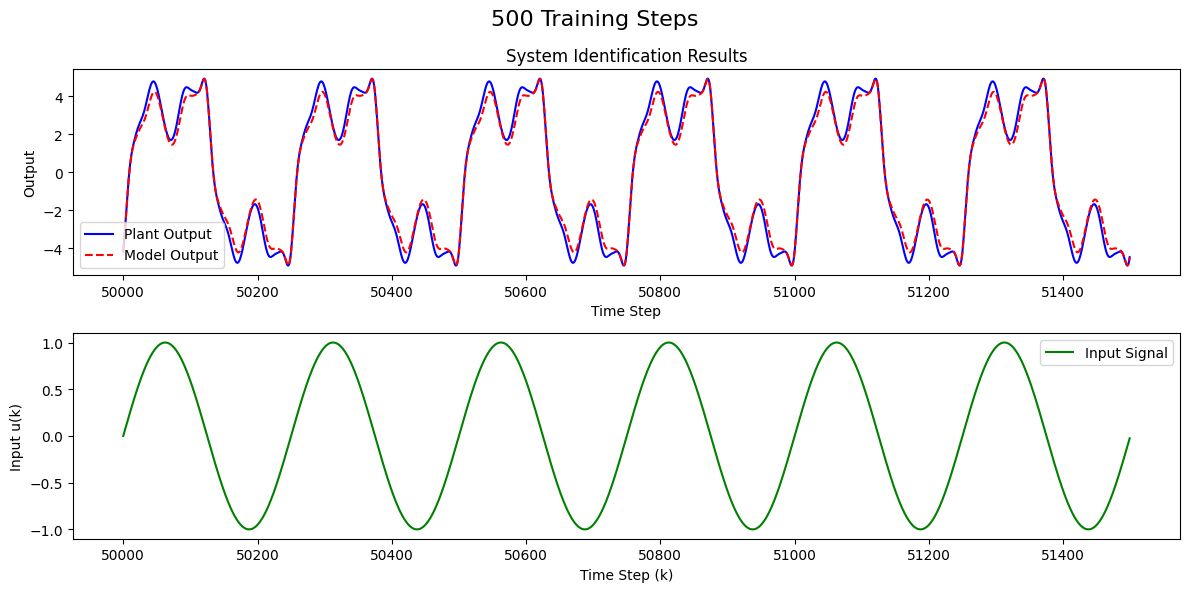

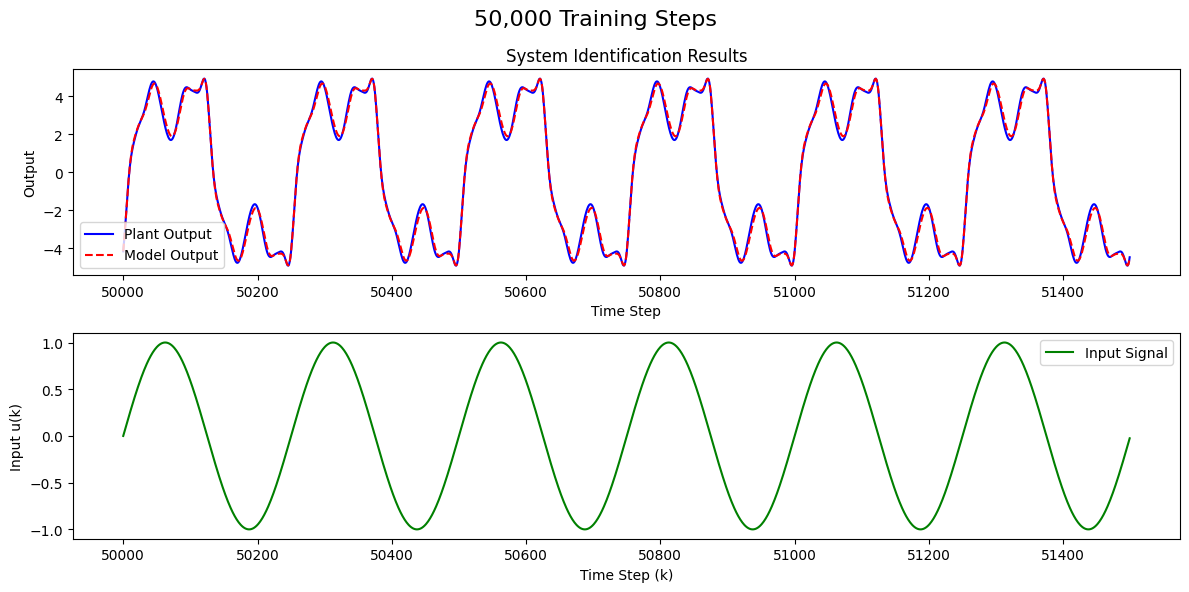

In [103]:
n_steps = 51500  #num steps in the paper its 5000
T = 1.0
t = np.arange(n_steps) * T

#the input we see
u = np.sin(2 * np.pi * t / 250)

#we have to init the frist two values as the model will look back to (k-1) and (k-2)
plant_output = [0.0, 0.0]  
model_output = [0.0, 0.0]  

# init the model
model = SeriesParallelModel([1, 20, 10, 1], 0.25)

# sim loop but we stop training at 500 
for k in range(2, n_steps):
    #clac the y
    y = 0.3 * plant_output[k-1] + 0.6 * plant_output[k-2] + plant_function(u[k])
    plant_output.append(y)
    
    # calc the y(hat)
    nn_output = model.forward(u[k])
    y_hat = 0.3 * plant_output[k-1] + 0.6 * plant_output[k-2] + nn_output
    model_output.append(y_hat)
    
    if k <500:
        #train step so calc error and update N[]
        model.train(u[k], plant_function(u[k]))

plotter(u[50000:], t[50000:], plant_output[50000:], model_output[50000:], f'500 Training Steps')

#sim loop but we keep training
plant_output = [0.0, 0.0]  
model_output = [0.0, 0.0]  

# init the model
model = SeriesParallelModel([1, 20, 10, 1], 0.25)

# sim loop but we stop training at 500 
for k in range(2, n_steps):
    #clac the y
    y = 0.3 * plant_output[k-1] + 0.6 * plant_output[k-2] + plant_function(u[k])
    plant_output.append(y)
    
    # calc the y(hat)
    nn_output = model.forward(u[k])
    y_hat = 0.3 * plant_output[k-1] + 0.6 * plant_output[k-2] + nn_output
    model_output.append(y_hat)
    
    #train step so calc error and update N[]
    if k < 50000:
        model.train(u[k], plant_function(u[k]))

plotter(u[50000:], t[50000:], plant_output[50000:], model_output[50000:], f'50,000 Training Steps')



_____